In [1]:
import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib . pyplot as plt


from scipy.integrate import odeint,solve_ivp
go_adjoint = True

!pip install torchdiffeq --quiet

if go_adjoint :
  from torchdiffeq import odeint_adjoint as odeint
else :
  from torchdiffeq import odeint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# System (Van der Pol)

In [2]:
def F_van_der_Pol(t,x,gamma=1):
 F1 = gamma*(x[0] - (x[0]**3)/3 - x[1])
 F2 = x[0]/gamma
 return np.array([F1,F2])

# Reservoir


In [3]:
class Reservoir:

    def __init__(self,in_out_dim=3, rho=1.1, n_neurons=300):
        self.in_out_dim = in_out_dim
        self.n_neurons = n_neurons

        A = np.random.uniform(low=-1,high=1, size=(self.n_neurons,self.n_neurons)) * (np.random.rand(self.n_neurons,self.n_neurons)<0.08).astype(float)
        _,S,_ = np.linalg.svd(A)

        self.W = (A/np.amax(S))*rho

        #other weights
        self.wIN = np.random.uniform(low=-0.3,high=0.3,size=(self.n_neurons,in_out_dim))
        self.wOUT = np.zeros((in_out_dim,self.n_neurons)).astype(float)

        #initialize memory
        self.r = np.zeros([self.n_neurons,1])

    def sigmoid(self,x):
      return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

    def step(self,x):
        x = np.array(x).reshape([self.in_out_dim,1])
        self.r = self.sigmoid(np.matmul(self.W,self.r)+np.matmul(self.wIN,x))
        O = np.matmul(self.wOUT,self.r)

        return O

    def clear_memory(self):
        self.r = np.zeros([self.n_neurons,1])

    def train(self,X,verbose=False):
        k = 0.000001
        T = X.shape[1]-1

        R = np.zeros([self.n_neurons,self.n_neurons])
        Q = np.zeros([self.n_neurons,self.in_out_dim])

        for t in range(0,T):
            if verbose:print("\riteration:{}/{}".format(t+1,T),end='')
            Yt = np.array(X[:,t+1]).reshape([self.in_out_dim,1])
            Ot = self.step(X[:,t])

            R += np.matmul(self.r,self.r.transpose())
            Q += np.matmul(self.r,Yt.transpose())
        if verbose:
            print()
            print("computing...")

        self.wOUT = np.matmul(np.linalg.inv(R+k*np.eye(self.n_neurons)),Q).transpose()
        if verbose:print('done!')

# NODE

In [7]:
class ODEFunc(nn.Module):

  def __init__(self, u_dim=2, n_hidden=256):
    super(ODEFunc, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(u_dim, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, u_dim)
    )

  def forward(self, t, u):
    return self.net(u)


def get_batch(traj):
  s = np.arange(len(traj)-1)
  batch_u0 = traj[s] #(M,D)
  batch_t = t[:2] #T
  batch_u = torch.stack([traj[s+i] for i in range(2)], dim=0) #(T,M,D)
  return batch_u0.to(device), batch_t.to(device), batch_u.to(device)

In [8]:
class RunningAverageMeter(object):
  def __init__(self,momentum=.99):
    self.momentum = momentum
    self.reset()

  def reset(self):
    self.val = None
    self.avg = 0

  def update(self, val):
    if self.val is None:
      self.avg = val
    else:
      self.avg = self.avg * self.momentum + val * (1- self.momentum) #linear combination!

    self.val = val

In [9]:
def visualize(y, y_hat, dt=0.1, dim=2):
  predicted_time = max_predicted_time(y, y_hat,dt=dt)
  for dim in range(dim):
      plt.figure(figsize=(10,3))
      plt.plot(t, y_hat[:,dim], color='C0', label='predicted')
      plt.plot(t, y[:,dim], color='C1', label='real')
      plt.plot(predicted_time*np.ones(2), [y_hat[:,dim].min(),y_hat[:,dim].max()],'k--', label="divergence time")

      plt.legend()
      plt.show()


  # ax = plt.axes(projection='3d')
  # #ax.plot3D(y_hat[:,0], y_hat[:, 1], y_hat[:, 2],color="C0", label='predicted')
  # ax.plot3D(y[:,0], y[:, 1], y[:, 2],color="C1", label='real')
  # plt.show()

def max_predicted_time(y,y_obs,tol=4,dt=0.1):
  max_T = 0
  for max_T in range(y.shape[0]):
       if np.abs(y[max_T,:] - y_obs[max_T,:]).max() > tol:
        break
  return max_T*dt



# MAIN CODE:

In [4]:
#PARAMS
n_iters = 200
test_freq = 50

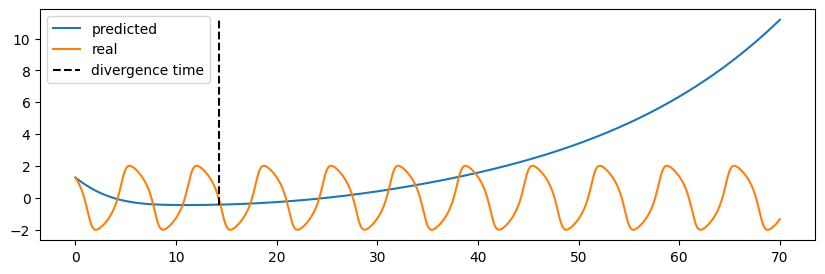

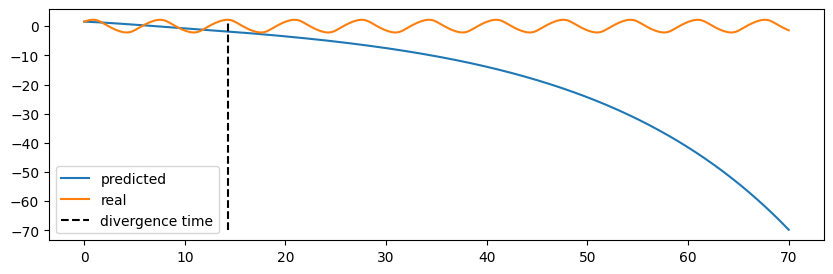

Iter 0001 | Total Loss 341.930176
Iter 0002 | Total Loss 0.008175
Iter 0003 | Total Loss 0.205755
Iter 0004 | Total Loss 0.029639
Iter 0005 | Total Loss 0.010616
Iter 0006 | Total Loss 0.009741
Iter 0007 | Total Loss 0.009024
Iter 0008 | Total Loss 0.008294
Iter 0009 | Total Loss 0.008655
Iter 0010 | Total Loss 0.007926
Iter 0011 | Total Loss 0.008064
Iter 0012 | Total Loss 0.007377
Iter 0013 | Total Loss 0.006977
Iter 0014 | Total Loss 0.006305
Iter 0015 | Total Loss 0.005288
Iter 0016 | Total Loss 0.004670
Iter 0017 | Total Loss 0.003385
Iter 0018 | Total Loss 0.002990
Iter 0019 | Total Loss 0.004759
Iter 0020 | Total Loss 0.002032
Iter 0021 | Total Loss 0.002027
Iter 0022 | Total Loss 0.001177
Iter 0023 | Total Loss 0.001612
Iter 0024 | Total Loss 0.001483
Iter 0025 | Total Loss 0.000963
Iter 0026 | Total Loss 0.001167
Iter 0027 | Total Loss 0.000970
Iter 0028 | Total Loss 0.000547
Iter 0029 | Total Loss 0.000326
Iter 0030 | Total Loss 0.000584
Iter 0031 | Total Loss 0.000335
Iter 0

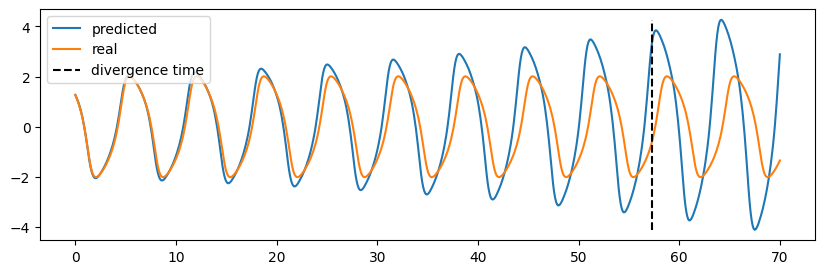

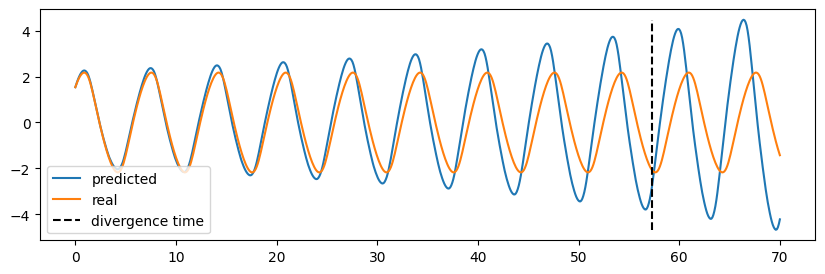

Iter 0050 | Total Loss 2.241170
Iter 0051 | Total Loss 0.000038
Iter 0052 | Total Loss 0.000030
Iter 0053 | Total Loss 0.000022
Iter 0054 | Total Loss 0.000031
Iter 0055 | Total Loss 0.000031
Iter 0056 | Total Loss 0.000021
Iter 0057 | Total Loss 0.000023
Iter 0058 | Total Loss 0.000020
Iter 0059 | Total Loss 0.000014
Iter 0060 | Total Loss 0.000016
Iter 0061 | Total Loss 0.000012
Iter 0062 | Total Loss 0.000010
Iter 0063 | Total Loss 0.000012
Iter 0064 | Total Loss 0.000013
Iter 0065 | Total Loss 0.000011
Iter 0066 | Total Loss 0.000006
Iter 0067 | Total Loss 0.000005
Iter 0068 | Total Loss 0.000005
Iter 0069 | Total Loss 0.000005
Iter 0070 | Total Loss 0.000007
Iter 0071 | Total Loss 0.000005
Iter 0072 | Total Loss 0.000004
Iter 0073 | Total Loss 0.000004
Iter 0074 | Total Loss 0.000002
Iter 0075 | Total Loss 0.000003
Iter 0076 | Total Loss 0.000004
Iter 0077 | Total Loss 0.000003
Iter 0078 | Total Loss 0.000003
Iter 0079 | Total Loss 0.000002
Iter 0080 | Total Loss 0.000002
Iter 008

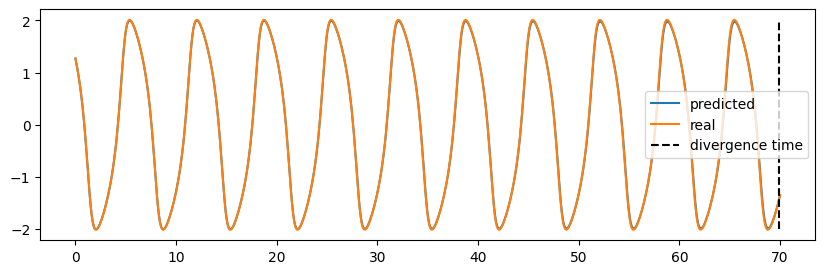

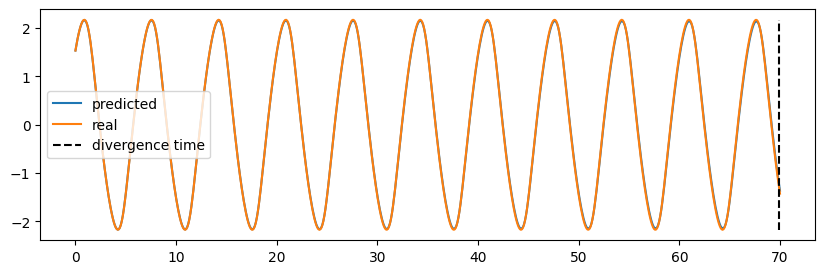

Iter 0100 | Total Loss 0.000662
Iter 0101 | Total Loss 0.000000
Iter 0102 | Total Loss 0.000000
Iter 0103 | Total Loss 0.000000
Iter 0104 | Total Loss 0.000000
Iter 0105 | Total Loss 0.000000
Iter 0106 | Total Loss 0.000000
Iter 0107 | Total Loss 0.000000
Iter 0108 | Total Loss 0.000000
Iter 0109 | Total Loss 0.000000
Iter 0110 | Total Loss 0.000000
Iter 0111 | Total Loss 0.000000
Iter 0112 | Total Loss 0.000000
Iter 0113 | Total Loss 0.000000
Iter 0114 | Total Loss 0.000000
Iter 0115 | Total Loss 0.000000
Iter 0116 | Total Loss 0.000000
Iter 0117 | Total Loss 0.000000
Iter 0118 | Total Loss 0.000000
Iter 0119 | Total Loss 0.000000
Iter 0120 | Total Loss 0.000000
Iter 0121 | Total Loss 0.000000
Iter 0122 | Total Loss 0.000000
Iter 0123 | Total Loss 0.000000
Iter 0124 | Total Loss 0.000000
Iter 0125 | Total Loss 0.000000
Iter 0126 | Total Loss 0.000000
Iter 0127 | Total Loss 0.000000
Iter 0128 | Total Loss 0.000000
Iter 0129 | Total Loss 0.000000
Iter 0130 | Total Loss 0.000000
Iter 013

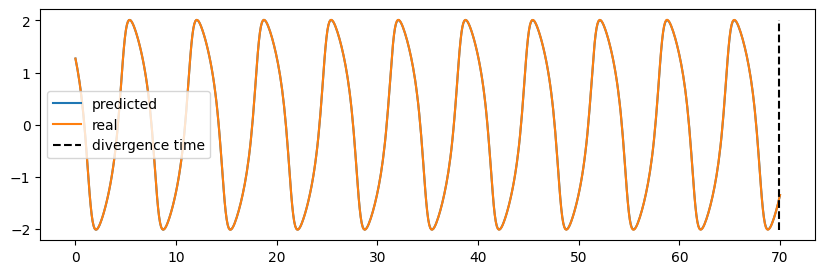

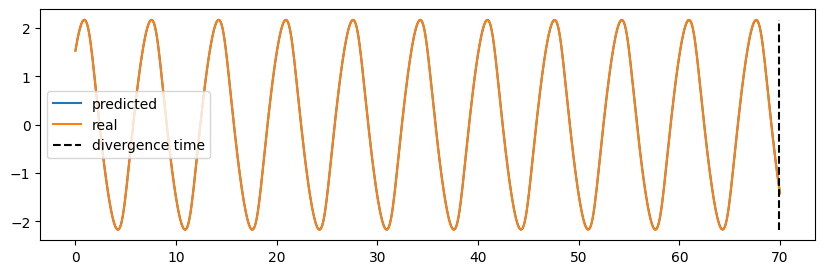

Iter 0150 | Total Loss 0.000034
Iter 0151 | Total Loss 0.000000
Iter 0152 | Total Loss 0.000000
Iter 0153 | Total Loss 0.000000
Iter 0154 | Total Loss 0.000000
Iter 0155 | Total Loss 0.000000
Iter 0156 | Total Loss 0.000000
Iter 0157 | Total Loss 0.000000
Iter 0158 | Total Loss 0.000000
Iter 0159 | Total Loss 0.000000
Iter 0160 | Total Loss 0.000000
Iter 0161 | Total Loss 0.000000
Iter 0162 | Total Loss 0.000000
Iter 0163 | Total Loss 0.000000
Iter 0164 | Total Loss 0.000000
Iter 0165 | Total Loss 0.000000
Iter 0166 | Total Loss 0.000000
Iter 0167 | Total Loss 0.000000
Iter 0168 | Total Loss 0.000000
Iter 0169 | Total Loss 0.000000
Iter 0170 | Total Loss 0.000000
Iter 0171 | Total Loss 0.000000
Iter 0172 | Total Loss 0.000000
Iter 0173 | Total Loss 0.000000
Iter 0174 | Total Loss 0.000000
Iter 0175 | Total Loss 0.000000
Iter 0176 | Total Loss 0.000000
Iter 0177 | Total Loss 0.000000
Iter 0178 | Total Loss 0.000000
Iter 0179 | Total Loss 0.000000
Iter 0180 | Total Loss 0.000000
Iter 018

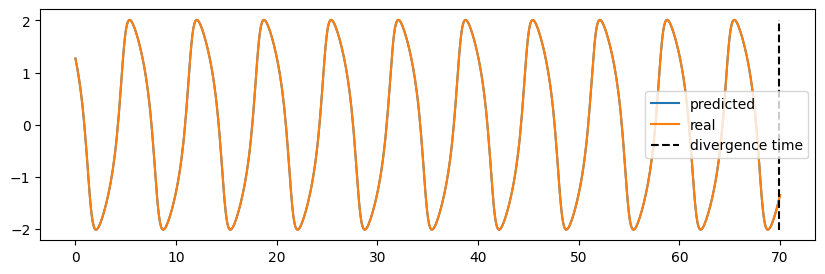

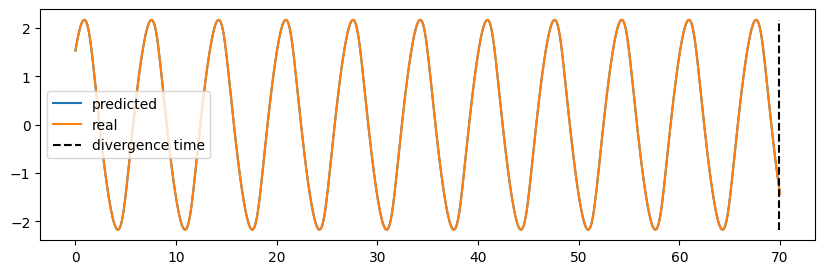

Iter 0200 | Total Loss 0.000001


In [10]:
#generate the actual data:

dt = 0.1
T = 500
N = int(T/dt)
t = torch.linspace(0., T, N).to(device)

times = np.arange(0,T,dt)
sol = solve_ivp(F_van_der_Pol, [0,T], [1,1], t_eval=times)
X = sol.y

#90%
data_size = 700
split_indx = int(len(times)*0.9)
val_T = T*0.9
times_train = times[:split_indx]
X_train = X[:,:split_indx]
true_fU = torch.tensor(np.transpose(X_train[:,-data_size:]), dtype=torch.float).to(device)
t = torch.linspace(0, int(data_size*dt), data_size).to(device)

#10% for validation
times_val = torch.tensor(times[split_indx:]).to(device)
X_val = torch.tensor(np.transpose(X[:,split_indx:]), dtype=torch.float).to(device)

#train NODE:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=10**-2)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)


for itr in range(1, n_iters + 1):
  optimizer.zero_grad()
  batch_u0, batch_t, batch_u = get_batch(true_fU)
  pred_fU = odeint(func, batch_u0, batch_t, method='rk4').to(device)

  loss = F.mse_loss(pred_fU, batch_u)
  loss.backward()
  optimizer.step()

  time_meter.update(time.time() - end)
  loss_meter.update(loss.item())

  if itr % test_freq == 0 or itr == 1:
    if itr > 1800:
      optimizer.param_groups[0]['lr'] = 10**-3
    with torch.no_grad():
      pred_fU = odeint(func, true_fU[0], t, method='rk4')
      loss = F.mse_loss(pred_fU, true_fU)

      #plot:
      visualize(true_fU, pred_fU,dt=dt)

  print('Iter {:04d} | Total Loss {:.6f}'.format(itr , loss.item()))
  ii += 1

In [11]:
res = Reservoir(in_out_dim=2,rho=0.001)
res.train(X_train[:,-data_size:],verbose=True)

#do prediction then:
print(X_val.shape)
X_res = np.zeros(X_val.shape)
X_res[0,:] = X_val[0,:].numpy()
for t in range(1,X_res.shape[0]):
  X_res[t,:] = res.step(X_res[t-1,:]).reshape(-1)

iteration:699/699
computing...
done!
torch.Size([500, 2])


<ipython-input-14-2a6672813854>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float)


NODE max time:49.900000000000006
RES. max time:49.900000000000006


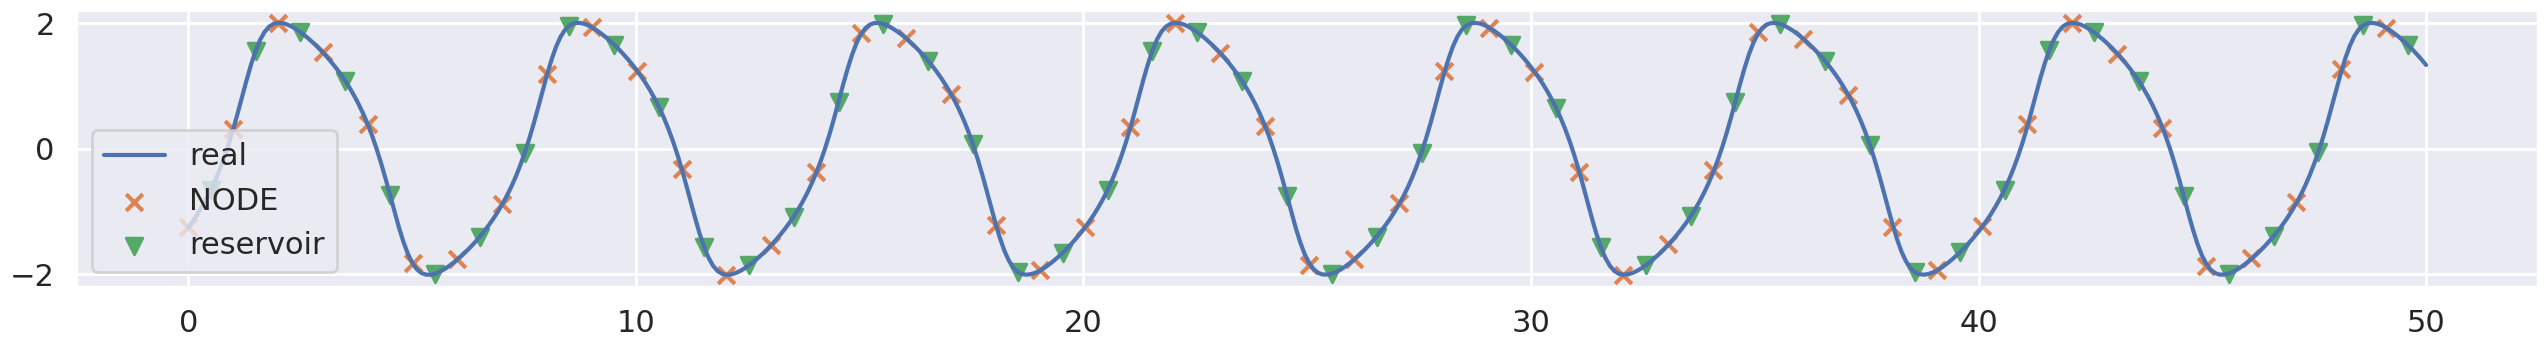

In [14]:
import seaborn as sns
sns.set_theme("poster")


X_val = torch.tensor(X_val, dtype=torch.float)
starting_point = X_val[0,:]
I = torch.linspace(0,T-val_T,len(times) - split_indx)
y_pred = odeint(func, starting_point, I, method="rk4").detach().numpy()

predicted_time_node = max_predicted_time(X_val, y_pred,tol=0.5,dt=dt)
print(f"NODE max time:{predicted_time_node}")
predicted_time_res = max_predicted_time(X_val, X_res,tol=0.5, dt=dt)
print(f"RES. max time:{predicted_time_res}")
for dim in range(2):
      plt.figure(figsize=(26,4))
      mask = np.arange(0,len(I)) % 10 == 0
      mask_2 = (np.arange(0,len(I))+5) % 10 == 0

      plt.plot(I, X_val[:,dim],  color='C0', label='real')
      plt.scatter(I[mask], y_pred[:,dim][mask],  color='C1', label='NODE', marker="x")
      plt.scatter(I[mask_2], X_res[:,dim][mask_2],  color='C2', label='reservoir', marker='v')

      #plt.plot(predicted_time*np.ones(2), [y_pred[:,dim].min(),y_pred[:,dim].max()],'k--', label="divergence time")

      plt.legend()
      plt.tight_layout()
      plt.savefig('van_der_pol.png',dpi=600)
      plt.show()
      break
